In [1]:
import pandas as pd
import pyarrow as pa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pysam
import itertools
import duckdb
from upsetplot import from_memberships, plot

In [2]:
# Disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# tools = ['flair', 'isoquant', 'isotools_v0', 'isotools_v1', 'isotools_v2', 'stringtie']
# tools = ['isoquant', 'isotools_v0', 'isotools_v1', 'isotools_v2']
tools = ['isotools_v0', 'isotools2']
tissue = 'brain'

In [4]:
gtf_path = "/project/hfa_work/ENCODE/code/snakemake-pipeline/results/{tool}/transcriptome/{tissue}_sorted.gtf.gz"

In [5]:
def get_tabix(tool, tissue):
    if tool == 'isotools2':
        tool = 'isotools_v0'
    return pysam.TabixFile(gtf_path.format(tool=tool, tissue=tissue))

In [6]:
tss_error = 0
pas_error = 0
junction_error = 0

In [7]:
def tool_transcriptome(tool):
    transcripts = []
    exon_list = []
    exon_count = {}
    tabix = get_tabix(tool, tissue)
    for row in tabix.fetch(parser=pysam.asGTF()):
        if row.feature == "transcript":
            transcripts.append((row.transcript_id, row.contig, int(row.start), int(row.end), row.strand))
        elif row.feature == "exon":
            exon_count.setdefault(row.transcript_id, 0)
            exon_list.extend([
                (row.transcript_id, 2 * exon_count[row.transcript_id], int(row.start)),
                (row.transcript_id, 2 * exon_count[row.transcript_id] + 1, int(row.end))])
            exon_count[row.transcript_id] += 1

    transcriptome = pd.DataFrame(transcripts, columns=["transcript_id", "chr", "start", "end", "strand"])
    transcriptome["min_start"] = np.where(transcriptome["strand"] == '+', transcriptome["start"] - tss_error, transcriptome["start"] - pas_error)
    transcriptome["max_start"] = np.where(transcriptome["strand"] == '+', transcriptome["start"] + tss_error, transcriptome["start"] + pas_error)
    transcriptome["min_end"] = np.where(transcriptome["strand"] == '+', transcriptome["end"] - pas_error, transcriptome["end"] - tss_error)
    transcriptome["max_end"] = np.where(transcriptome["strand"] == '+', transcriptome["end"] + pas_error, transcriptome["end"] + tss_error)

    exons = pd.DataFrame(exon_list, columns=["transcript_id", "index", "position"])
    transcriptome.set_index("transcript_id", inplace=True)
    transcriptome["max_splice_site_index"] = exons.groupby("transcript_id").max()["index"]
    transcriptome.reset_index(inplace=True, names=["transcript_id"])

    transcriptome.to_csv(f"results/{tool}_transcriptome.tsv", sep="\t", index=False)

    exons.to_csv(f"results/{tool}_exons.tsv", sep="\t", index=False)

    return transcriptome, exons


def add_transcript_overlap_duckdb(tool, tool_overlap, overlap_exons, remove_duplicates=True):
    transcriptome, new_exons = tool_transcriptome(tool)

    if tool_overlap.empty:
        tool_overlap = pd.concat([tool_overlap, transcriptome])
        tool_overlap[tool] = transcriptome["transcript_id"]
        tool_overlap["id"] = tool + transcriptome["transcript_id"]
        tool_overlap.drop(columns=["transcript_id"], inplace=True)

        new_exons['id'] = tool + new_exons["transcript_id"]
        new_exons.drop(columns=["transcript_id"], inplace=True)
        overlap_exons = pd.concat([overlap_exons, new_exons])

        return tool_overlap, overlap_exons

    query = f"""
SELECT
    tool_ol.id,
    t.transcript_id
FROM tool_overlap AS tool_ol
JOIN transcriptome t ON
    tool_ol.chr = t.chr AND
    tool_ol.start >= t.min_start AND
    tool_ol.start <= t.max_start AND
    tool_ol.end >= t.min_end AND
    tool_ol.end <= t.max_end AND
    tool_ol.strand = t.strand AND
    tool_ol.max_splice_site_index = t.max_splice_site_index
JOIN new_exons ne ON
    ne.transcript_id = t.transcript_id
JOIN overlap_exons oe ON
    oe.id = tool_ol.id AND
    oe.index = ne.index AND
    (
        ABS(oe.position - ne.position) <= {junction_error} OR
        oe.index = 0 OR
        oe.index = t.max_splice_site_index
    )
GROUP BY
    tool_ol.id,
    t.transcript_id
HAVING
    COUNT(*) = MAX(t.max_splice_site_index) + 1
               """

    matches = duckdb.sql(query).df()
    # print("matches", matches)
    # print("tool_overlap", tool_overlap)
    # print("transcriptome", transcriptome)

    # Happens when multiple transcripts from the new tool match the same transcript from the previous tools
    # or when a transcript from the new tool matches multiple transcripts from the previous tools
    if remove_duplicates:
        print("with duplicates:", matches.shape)
        matches = matches.drop_duplicates(subset=["id"]).drop_duplicates(subset=["transcript_id"])
        print("without duplicates", matches.shape)

    # Add matches to the df
    tool_overlap = tool_overlap.merge(matches, on="id", how="left")
    tool_overlap[tool] = tool_overlap["transcript_id"]
    tool_overlap.drop(columns=["transcript_id"], inplace=True)

    # Add mismatches to the df
    transcriptome_filtered = transcriptome.set_index("transcript_id").drop(matches["transcript_id"].to_list()).reset_index(names=["transcript_id"])
    transcriptome_filtered[tool] = transcriptome_filtered["transcript_id"]
    transcriptome_filtered["id"] = tool + transcriptome_filtered["transcript_id"]
    transcriptome_filtered.drop(columns=["transcript_id"], inplace=True)
    tool_overlap = pd.concat([tool_overlap, transcriptome_filtered])
    tool_overlap.to_csv("results/overlap.tsv", sep="\t")

    # Add exons for mismatches
    new_exons['id'] = tool + new_exons["transcript_id"]
    new_exons.drop(columns=["transcript_id"], inplace=True)
    # Filter new_exons to only contain exons of transcriptome_filtered
    new_exons = new_exons[new_exons["id"].isin(transcriptome_filtered["id"])]
    overlap_exons = pd.concat([overlap_exons, new_exons])
    overlap_exons.to_csv("results/overlap_exons.tsv", sep="\t")

    return tool_overlap, overlap_exons

overlap = pd.DataFrame(columns=["chr", "start", "end", "strand", "max_splice_site_index", *tools])
overlap_exons = pd.DataFrame(columns=["id", "index", "position"])

for tool in tools:
    print("Processing", tool)
    overlap, overlap_exons = add_transcript_overlap_duckdb(tool, overlap, overlap_exons, remove_duplicates=False)

Processing isotools_v0
Processing isotools2


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [8]:
overlap

,chr,start,end,strand,max_splice_site_index,isotools_v0,isotools2,min_start,max_start,min_end,max_end,id
0,chr1,14405,24894,-,19,ENSG00000227232.6_30,ENSG00000227232.6_30,14405.0,14405.0,24894.0,24894.0,isotools_v0ENSG00000227232.6_30
1,chr1,14405,29352,-,21,ENSG00000227232.6_3,ENSG00000227232.6_3,14405.0,14405.0,29352.0,29352.0,isotools_v0ENSG00000227232.6_3
2,chr1,14406,14490,-,1,PB_novel_127367_0,PB_novel_127367_0,14406.0,14406.0,14490.0,14490.0,isotools_v0PB_novel_127367_0
3,chr1,134920,135453,-,1,ENSG00000268903.1_0,ENSG00000268903.1_0,134920.0,134920.0,135453.0,135453.0,isotools_v0ENSG00000268903.1_0
4,chr1,139282,164673,+,11,PB_novel_00006_4,PB_novel_00006_4,139282.0,139282.0,164673.0,164673.0,isotools_v0PB_novel_00006_4
...,...,...,...,...,...,...,...,...,...,...,...,...
55374,chrY,57067862,57130284,+,15,ENSG00000292366.1_0,ENSG00000292366.1_0,57067862.0,57067862.0,57130284.0,57130284.0,isotools_v0ENSG00000292366.1_0
55375,chrY,57067862,57130284,+,13,ENSG00000292366.1_2,ENSG00000292366.1_2,57067862.0,57067862.0,57130284.0,57130284.0,isotools_v0ENSG00000292366.1_2
55376,chrY,57067862,57130284,+,13,ENSG00000292366.1_4,ENSG00000292366.1_4,57067862.0,57067862.0,57130284.0,57130284.0,isotools_v0ENSG00000292366.1_4
55377,chrY,57208919,57212183,+,13,ENSG00000292372.1_5,ENSG00000292372.1_5,57208919.0,57208919.0,57212183.0,57212183.0,isotools_v0ENSG00000292372.1_5


In [9]:
# iterate over all combination of tools and count the number of transcripts that are shared
combinations = itertools.chain.from_iterable(itertools.combinations(tools, r) for r in range(1, len(tools) + 1))

counts = []
for combination in combinations:
    inverted_combination = [tool for tool in tools if tool not in combination]
    counts.append((combination,
                   overlap[[*combination]].dropna().shape[0],
                   overlap[(overlap[inverted_combination].isna().all(axis=1)) & (overlap[[*combination]].notna().all(axis=1))].shape[0]))

counts = pd.DataFrame(counts, columns=["tools", "shared", "unique"])
counts

,tools,shared,unique
0,"(isotools_v0,)",55379,0
1,"(isotools2,)",55379,0
2,"(isotools_v0, isotools2)",55379,55379


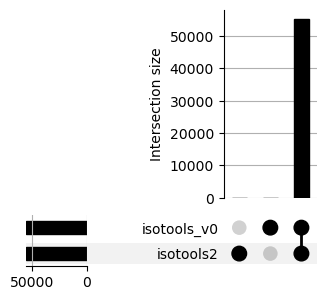

In [10]:
upset = from_memberships(counts["tools"].to_list(), data=counts["unique"].to_list())
plot(upset, orientation='horizontal', element_size=30)
plt.savefig(f"results/upset_{"_".join(tools)}.png")
plt.show()

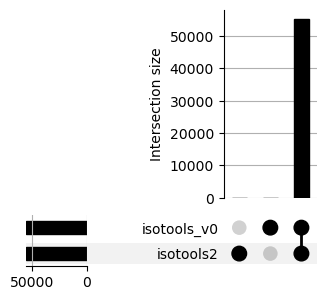

In [11]:
# remove stringtie and flair unique entries
counts_filtered = counts[(counts["tools"] != ("flair",)) & (counts["tools"] != ("stringtie",))]
upset = from_memberships(counts_filtered["tools"].to_list(), data=counts_filtered["unique"].to_list())
plot(upset, orientation='horizontal', element_size=30)
plt.savefig(f"results/upset_filtered_{"_".join(tools)}.png")
plt.show()

In [12]:
if 'isotools2' in tools:
    doubled = overlap[overlap['isotools_v0'] != overlap['isotools2']]
else:
    doubled = None
doubled

,chr,start,end,strand,max_splice_site_index,isotools_v0,isotools2,min_start,max_start,min_end,max_end,id
6115,chr10,69630252,69633590,+,1,ENSG00000171224.9_22,ENSG00000171224.9_5,69630252.0,69630252.0,69633590.0,69633590.0,isotools_v0ENSG00000171224.9_22
6117,chr10,69630252,69633590,+,1,ENSG00000171224.9_5,ENSG00000171224.9_22,69630252.0,69630252.0,69633590.0,69633590.0,isotools_v0ENSG00000171224.9_5
18469,chr16,1325723,1327016,+,1,ENSG00000103275.22_10,ENSG00000103275.22_9,1325723.0,1325723.0,1327016.0,1327016.0,isotools_v0ENSG00000103275.22_10
18472,chr16,1325723,1327016,+,1,ENSG00000103275.22_9,ENSG00000103275.22_10,1325723.0,1325723.0,1327016.0,1327016.0,isotools_v0ENSG00000103275.22_9
20449,chr16,70250229,70251933,-,1,ENSG00000223496.3_12,ENSG00000223496.3_9,70250229.0,70250229.0,70251933.0,70251933.0,isotools_v0ENSG00000223496.3_12
20451,chr16,70250229,70251933,-,1,ENSG00000223496.3_9,ENSG00000223496.3_12,70250229.0,70250229.0,70251933.0,70251933.0,isotools_v0ENSG00000223496.3_9
23543,chr17,60129187,60129785,+,1,PB_novel_107569_0,PB_novel_107570_0,60129187.0,60129187.0,60129785.0,60129785.0,isotools_v0PB_novel_107569_0
23545,chr17,60129187,60129785,+,1,PB_novel_107570_0,PB_novel_107569_0,60129187.0,60129187.0,60129785.0,60129785.0,isotools_v0PB_novel_107570_0
31886,chr2,161984597,161985268,+,1,ENSG00000144290.17_20,ENSG00000144290.17_27,161984597.0,161984597.0,161985268.0,161985268.0,isotools_v0ENSG00000144290.17_20
31888,chr2,161984597,161985268,+,1,ENSG00000144290.17_27,ENSG00000144290.17_20,161984597.0,161984597.0,161985268.0,161985268.0,isotools_v0ENSG00000144290.17_27
